In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd

# Criando um DataFrame para armazenar os dados
dados = pd.DataFrame(columns=['Proventos', 'Compras', 'Fluxo de Caixa', 'Faliu'])

fluxo_de_caixa_anterior = 0  # Inicializando o fluxo de caixa
dias = 30
dia_atual = pd.Timestamp('2023-09-01')

while dias >= 0:  # Limitando a simulação a 30 dias
    # Verifica se é o último dia do ciclo
    if dias == 0:
        if fluxo_de_caixa_do_dia < 0:
            dia_anterior = dia_atual - pd.Timedelta(days=1)
            dados.loc[dia_anterior, 'Faliu'] = True
            break
        else:
            # Reiniciando o ciclo de 30 dias
            dias = 30
            dados.loc[dia_atual, 'Faliu'] = False

    n_proventos = np.random.randint(0, 11)
    n_compras = np.random.randint(0, 11)

    # Gerando valores aleatórios para proventos e compras
    proventos = np.random.uniform(0, 10000, n_proventos).sum()
    compras = np.random.uniform(0, 10000 + 1 * (30 - dias), n_compras).sum()  # Aumentando o limite máximo à medida que os dias avançam

    # Calculando o fluxo de caixa do dia
    fluxo_de_caixa_do_dia = fluxo_de_caixa_anterior + proventos - compras

    # Adicionando os dados ao DataFrame usando loc
    dados.loc[dia_atual] = [proventos, compras, fluxo_de_caixa_do_dia, False]

    # Atualizando o fluxo de caixa anterior e o dia atual para o próximo dia
    fluxo_de_caixa_anterior = fluxo_de_caixa_do_dia
    dia_atual += pd.Timedelta(days=1)

    dias -= 1

# Convertendo valores para float para melhor manipulação posteriormente
dados = dados.astype(float)

# Exibindo os dados
print(dados)

               Proventos       Compras  Fluxo de Caixa  Faliu
2023-09-01  30554.056591  23307.089135     7246.967455    0.0
2023-09-02    917.274131   9592.382613    -1428.141027    0.0
2023-09-03      0.000000  27325.384818   -28753.525845    0.0
2023-09-04  26508.610342  11556.262976   -13801.178479    0.0
2023-09-05  28610.250405  45272.092263   -30463.020336    0.0
2023-09-06  62260.192155  46964.518336   -15167.346518    0.0
2023-09-07  34547.238572  16544.057783     2835.834272    0.0
2023-09-08   9735.626669  15706.621443    -3135.160502    0.0
2023-09-09  16064.415567  51627.180650   -38697.925585    0.0
2023-09-10  22773.724050  54649.684042   -70573.885577    0.0
2023-09-11  15080.223632  37833.020279   -93326.682224    0.0
2023-09-12      0.000000  15426.427334  -108753.109559    0.0
2023-09-13  24027.770329  49994.264658  -134719.603888    0.0
2023-09-14      0.000000  11543.843008  -146263.446897    0.0
2023-09-15  26604.223123  27867.739871  -147526.963645    0.0
2023-09-

In [8]:
import numpy as np
import pandas as pd

def simular_um_mes():
    dias = 30
    data_inicial = pd.date_range(start='2023-09-01', periods=dias, freq='D')
    dados = pd.DataFrame(index=data_inicial, columns=['Proventos', 'Compras', 'Fluxo de Caixa', 'Probabilidade de Falir', 'Risco de Falir'])
    dados[['Proventos', 'Compras', 'Fluxo de Caixa', 'Probabilidade de Falir']] = 0.0  # Inicializando com valores float

    fluxo_de_caixa_anterior = 0.0

    for dia_atual in data_inicial:
        n_proventos = np.random.randint(0, 11)
        n_compras = np.random.randint(0, 11)
        proventos = np.random.uniform(0, 10000, n_proventos).sum()
        compras = np.random.uniform(0, 10000 + 5 * (30 - (dia_atual - data_inicial[0]).days), n_compras).sum()

        fluxo_de_caixa_do_dia = fluxo_de_caixa_anterior + proventos - compras
        dados.loc[dia_atual, ['Proventos', 'Compras', 'Fluxo de Caixa']] = [proventos, compras, fluxo_de_caixa_do_dia]

        fluxo_de_caixa_anterior = fluxo_de_caixa_do_dia

    min_fluxo = dados['Fluxo de Caixa'].min()
    for index, row in dados.iterrows():
        normalized = (row['Fluxo de Caixa'] - min_fluxo) / -min_fluxo if min_fluxo < 0 else 0
        probabilidade = 1 - normalized
        dados.loc[index, 'Probabilidade de Falir'] = probabilidade
        dados.loc[index, 'Risco de Falir'] = (
            "Alto risco" if probabilidade >= 0.8 else
            "Em risco" if probabilidade >= 0.6 else
            "Equilibrado" if probabilidade >= 0.4 else
            "Baixa chance" if probabilidade >= 0.2 else
            "Sem chance"
        )

    return dados

casos = [simular_um_mes() for _ in range(15000)]

In [9]:
all_data = pd.concat(casos)
all_data.to_parquet('/content/drive/MyDrive/pedrao.parquet')
#all_data = pd.read_parquet('/content/drive/MyDrive/pedrao.parquet')

In [10]:
import tensorflow as tf

# Verifica se há GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configura o TensorFlow para usar a GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU instead.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [14]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def preprocess_data(data, sequence_length=30):
    data = data[['Proventos', 'Compras', 'Risco de Falir']]
    encoder = LabelEncoder()
    data['Risco de Falir'] = encoder.fit_transform(data['Risco de Falir'])
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['Proventos', 'Compras']])

    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data_scaled[i:i+sequence_length])
        y.append(data.iloc[i+sequence_length-1]['Risco de Falir'])

    X, y = np.array(X), np.array(y)

    # Usando SMOTE em vez de ADASYN
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X.reshape(X.shape[0], -1), y)
    X_res = X_res.reshape(-1, sequence_length, X.shape[2])

    return X_res, y_res, encoder.classes_

# Supondo que 'all_data' seja seu DataFrame de dados originais
#X, y, classes = preprocess_data(all_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=1)
performance = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {performance[0]}, Test Accuracy: {performance[1]}')


Epoch 1/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - accuracy: 0.4124 - loss: 1.3169 - val_accuracy: 0.4063 - val_loss: 1.3171
Epoch 2/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.4493 - loss: 1.2327 - val_accuracy: 0.4361 - val_loss: 1.2527
Epoch 3/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.4540 - loss: 1.2250 - val_accuracy: 0.4639 - val_loss: 1.2003
Epoch 4/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.4567 - loss: 1.2178 - val_accuracy: 0.4654 - val_loss: 1.2003
Epoch 5/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.4629 - loss: 1.2075 - val_accuracy: 0.4769 - val_loss: 1.1753
Epoch 6/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.4706 - loss: 1.1943 - val_accuracy: 0.4735 - val_loss: 1.1862
Epoch 7/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.4744 - loss: 1.1869 - val_accuracy: 0.4770 - val_loss: 1.1707
Epoch 8/10
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.4767 - loss: 1

In [17]:
# Save the entire model to a HDF5 file.
model.save('/content/drive/MyDrive/prediction_model.h5')

6860/6860 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


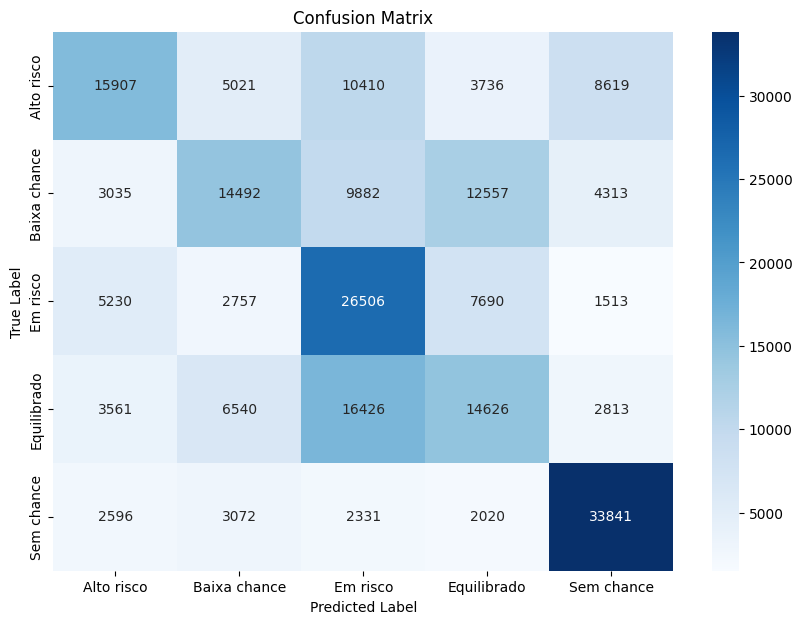

              precision    recall  f1-score   support

  Alto risco       0.52      0.36      0.43     43693
Baixa chance       0.45      0.33      0.38     44279
    Em risco       0.40      0.61      0.49     43696
 Equilibrado       0.36      0.33      0.35     43966
  Sem chance       0.66      0.77      0.71     43860

    accuracy                           0.48    219494
   macro avg       0.48      0.48      0.47    219494
weighted avg       0.48      0.48      0.47    219494

Weighted Avg Precision: 0.4810386709313474
Weighted Avg Recall: 0.4800677922858939
Weighted Avg F1-Score: 0.47061238731183175


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Suponha que 'y_pred' seja a previsão do modelo no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades para classes preditas

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Gerar relatório de classificação
report = classification_report(y_test, y_pred_classes, target_names=classes, output_dict=True)
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Exibir o weighted average de f1-score, precision e recall
print(f"Weighted Avg Precision: {report['weighted avg']['precision']}")
print(f"Weighted Avg Recall: {report['weighted avg']['recall']}")
print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']}")
